## San Diego COVID-19 History and Projections

For the past few weeks, the San Diego Regional Data Library has been scraping the offical COVID statistics from the County of San Diego. The data package is in the [Library's data repository](https://data.sandiegodata.org/dataset/sandiegodata-org-covid19-1-2-0/). Along with other data in the Library's collection, we now have neough observations to produce some estimates of the future growth of cases in the County 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf


In [2]:

pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19-1.2.0.csv') # .0 references the last upload
df = pkg.resource('sd_covid_cases').read_csv().fillna(0)
df.drop(columns=['notes'], inplace=True)

df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df.rename(columns={'hospitalized': 'hosp'}, inplace=True)
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp, df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths, df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.head().T

/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0,1,2,3,4
date,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
cases,8,10,20,39,55
cases_male,0,0,0,19,35
cases_female,0,0,0,20,20
hosp,0,0,0,12,10
intensive_care,0,0,0,0,0
deaths,0,0,0,0,0
day,0,1,2,3,4
cases_rate,NaN,0.25,1,0.95,0.410256
cases_smooth,-21.6201,-1.60828,18.791,39.5688,60.7031


In [3]:
df.date.max()

Timestamp('2020-04-08 00:00:00')

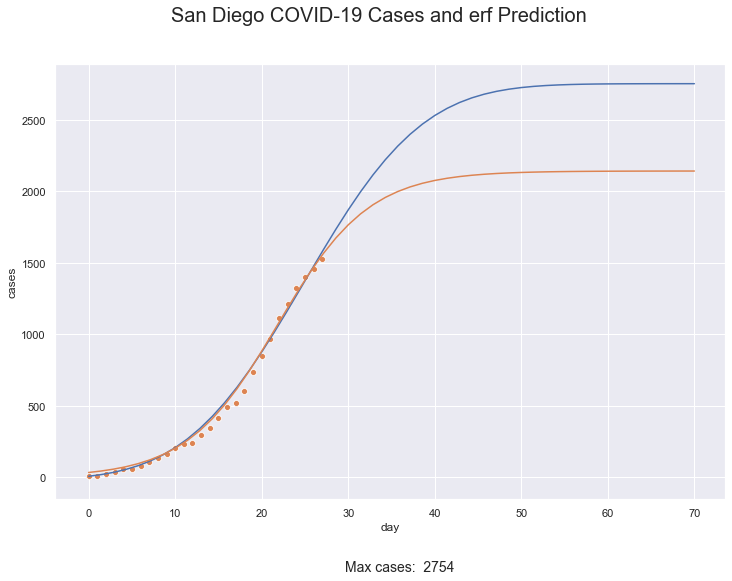

In [4]:

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)


def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def ln_fit(df, fig, ax, col_name, use_smooth=True, pred_days = 70, text=True, fit_func = func_erf):

    t = df.dropna(subset=['day',col_name])

    fit_col = col_name+'_smooth' if use_smooth else col_name
    
    popt, pcov = curve_fit(fit_func, t.day, t[fit_col], p0=fit_func.popt, absolute_sigma = True)
   
    x=np.linspace(0,pred_days)
    proj = fit_func(x, *popt)
    
    sns.lineplot(x=x, y=proj, ax=ax)
    
    sns.scatterplot(x='day', y=col_name, data=t, ax=ax)

    perr = np.sqrt(np.diag(pcov))
    
    max_cases = np.max(proj)
    
    if text: 
        plt.gcf().text(.46,-0,f"Max {col_name}: {max_cases:5.0f}", fontsize=14) 
    
    return popt, perr, x, proj

fig, ax = plt.subplots(figsize=(12,8))

t = df.copy()
#t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1]

popt, perr, x, cases_d_e = ln_fit(t[:], fig, ax, 'cases', fit_func = func_erf)

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_logistic)
 
fig.suptitle("San Diego COVID-19 Cases and erf Prediction", fontsize=20);


**On the downslope**. It looks like San Diego has hit its peak in new coronavirus cases. This plot shows the daily increase or decrease in the number of confirmed coronavirus cases for San Diego County. The full plot should look a lot like a Normal distribution ( aka bell curve ) so you can see that we'd just hit the peak a few days ago. From here out, we should see, each day, a smaller number of new cases than the day before.  

Death, how ever, have not hit the peak, because deaths lag cases by about 10 days. 


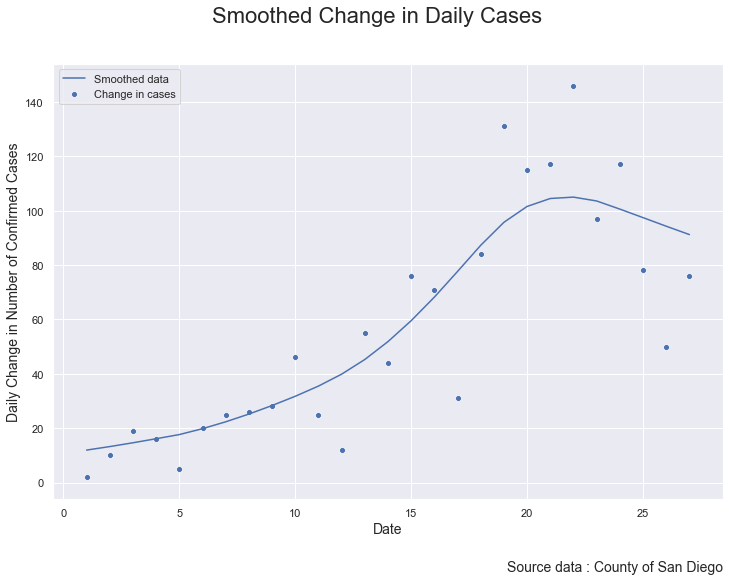

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("Smoothed Change in Daily Cases", fontsize=22);


t = df.copy()
t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1] 
td = lowess(t.cases.diff(), df.day, is_sorted=True, frac=0.4, it=0)[:,1]


ax.plot(df.day[1:], td, label='Smoothed data');
sns.scatterplot(t.day, df.cases.diff(), label='Change in cases');

ax.set_ylabel('Daily Change in Number of Confirmed Cases', fontsize=14)
ax.set_xlabel('Date', fontsize=14);
ax.legend(loc='upper left');

plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) ;


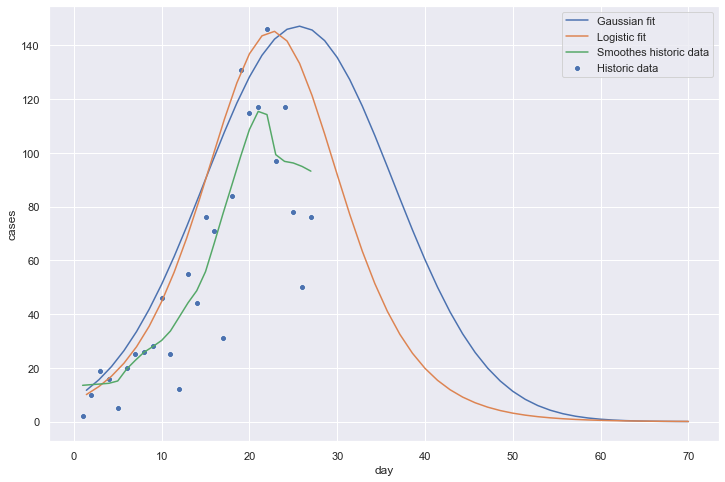

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x, pd.Series(cases_d_e).diff(), label='Gaussian fit' )
ax.plot(x, pd.Series(cases_d_l).diff(), label='Logistic fit' )

cases =  lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1] 
ax.plot(df.day, pd.Series(cases).diff(), label='Smoothes historic data' )

sns.scatterplot(df.day, df.cases.diff(), label='Historic data', ax=ax )

ax.legend()

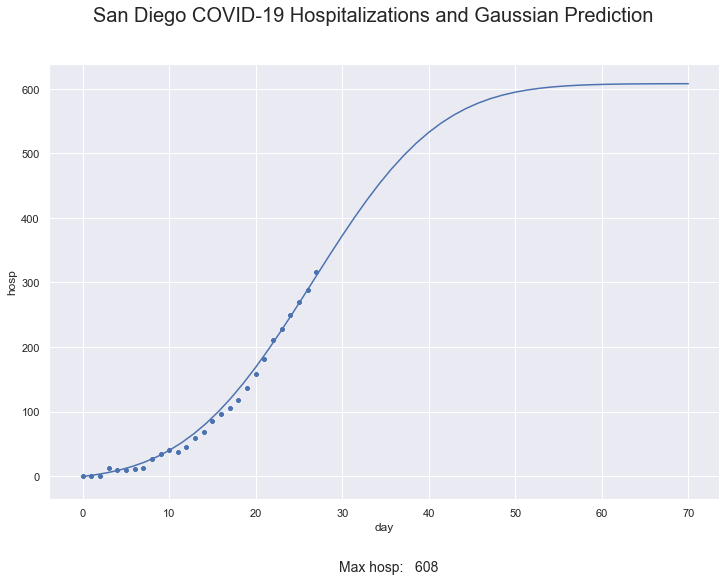

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, hosp_d = ln_fit(df, fig, ax, 'hosp')
fig.suptitle("San Diego COVID-19 Hospitalizations and Gaussian Prediction", fontsize=20);

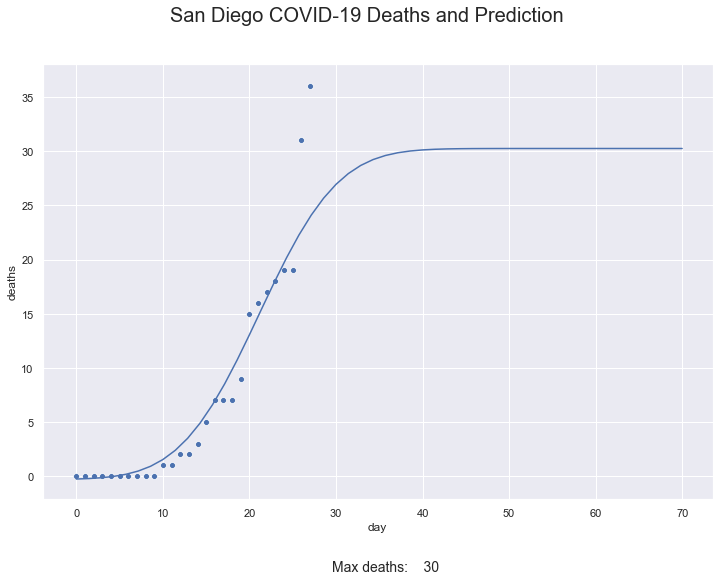

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, death_d = ln_fit(df, fig, ax, 'deaths')
fig.suptitle("San Diego COVID-19 Deaths and Prediction", fontsize=20);

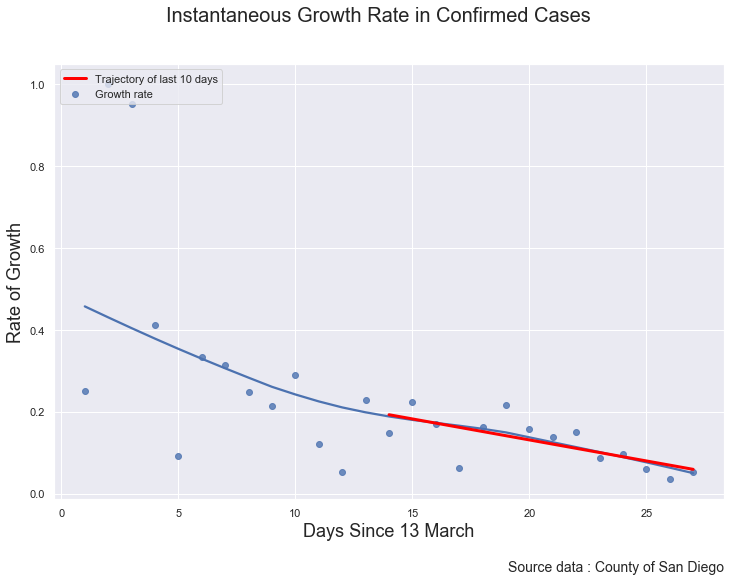

Coefficients: [[-0.0102567]] [0.33599393]
Zero growth at 32.75846966600294 days


In [9]:


def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)[-14:]
    y = df[col].values.reshape(len(df), 1)[-14:]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True, label = 'Growth rate')

    ax.plot(x, regr.predict(x), color='red', linewidth=3, label = 'Trajectory of last 10 days')

    ax.set_xlabel('Days Since 13 March', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    ax.legend(loc='upper left');
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    
    
    print(f"Zero growth at {-b/m} days")

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')
    

In [10]:
pkg = mp.open_package('http://library.metatab.org/covidtracking.com-covid19-3.1.0.csv')

states_df = pkg.resource('states').read_csv()

,35,34,33,32,31
date,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00
state,CA,CA,CA,CA,CA
positive,53,53,60,69,88
negative,462,462,462,462,462
pending,NaN,NaN,NaN,NaN,NaN
hospitalizedcurrently,NaN,NaN,NaN,NaN,NaN
hospitalizedcumulative,NaN,NaN,NaN,NaN,NaN
inicucurrently,NaN,NaN,NaN,NaN,NaN
inicucumulative,NaN,NaN,NaN,NaN,NaN
onventilatorcurrently,NaN,NaN,NaN,NaN,NaN


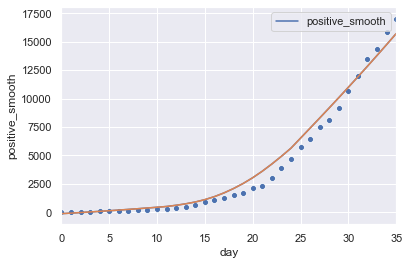

In [11]:
ca = states_df[states_df.state == 'CA'].copy().reset_index(drop=True)

ca['date'] = pd.to_datetime(ca.date, format='%Y%m%d' )
ca.sort_values('date', inplace=True)
ca.reset_index(drop=True)
ca['day'] = (ca.date - ca.date.min()).dt.days
ca['positive_smooth'] = lowess(ca.positive, ca.day)[:,1]

ca.head().T
ca.plot(x='day',y='positive_smooth')
sns.scatterplot(ca.day, ca.positive)
sns.lineplot(ca.day, ca.positive_smooth)
ca.head().T

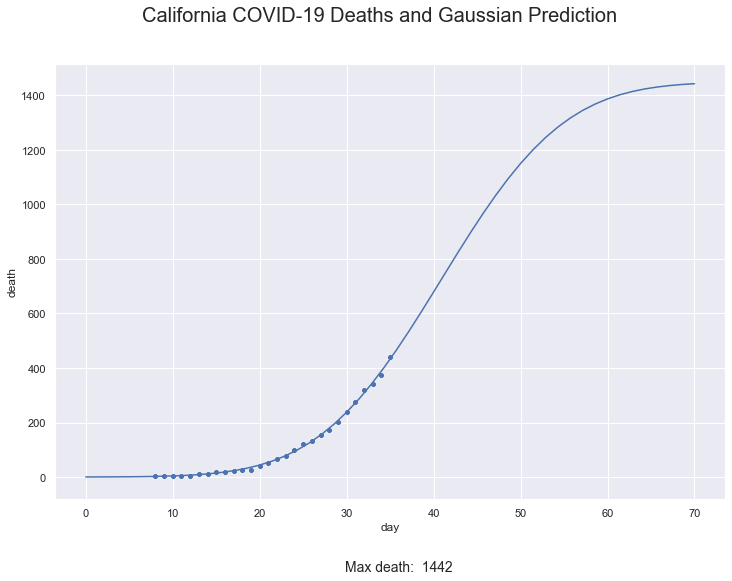

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, lnd  = ln_fit(ca, fig, ax, 'death', use_smooth=False, pred_days=70)
fig.suptitle("California COVID-19 Deaths and Gaussian Prediction", fontsize=20);

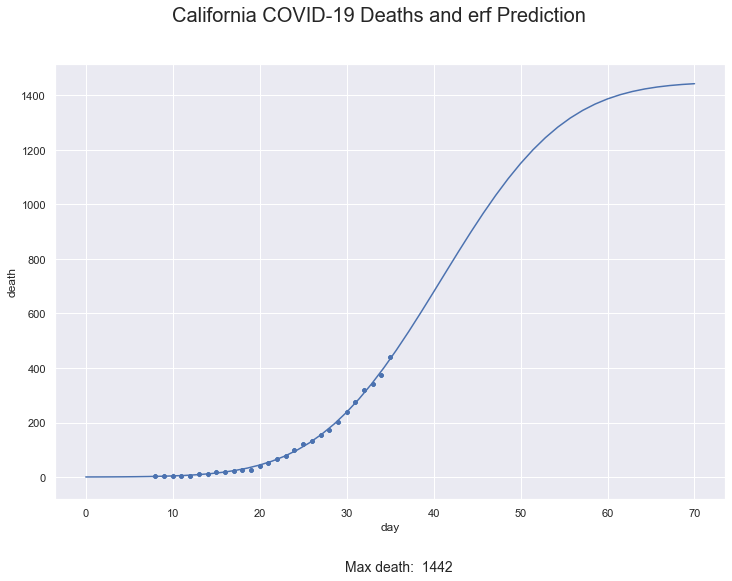

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
popt, perr, x, lnd  = ln_fit(ca, fig, ax, 'death', use_smooth=False, pred_days=70)
fig.suptitle("California COVID-19 Deaths and erf Prediction", fontsize=20);

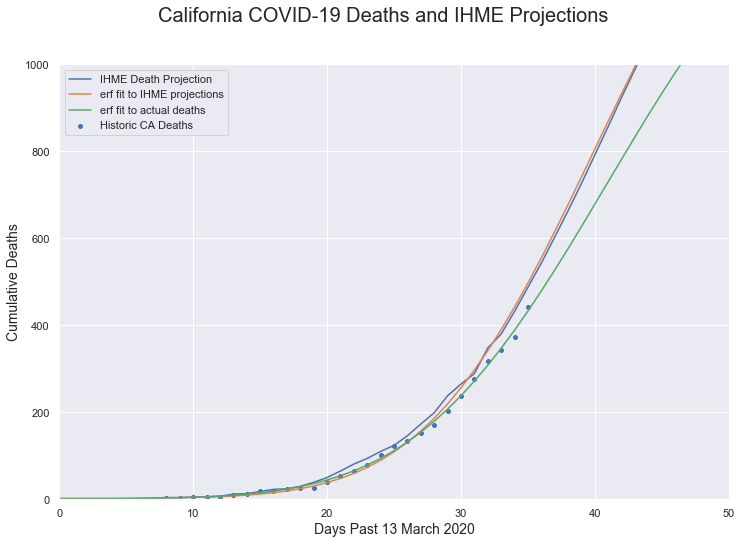

In [37]:

#ihme = pd.read_csv('hospitalization_all_locs_corrected.csv', parse_dates=True)

pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.0.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

t = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))


def func_logistic(x, loc, scale, a, b): # popt = (14,4, 800)
    return a*logistic.cdf(x+b, loc, scale)
func_logistic = (14,4, 800,0)

def func_norm(x, loc, scale, a, b):
    return a*norm.cdf(x, loc, scale) + b
func_norm.popt = (14,4, 800,0)

def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)


f = func_erf

popt, pcov = curve_fit(f, t.day, t.deaths_mean.cumsum(), p0=f.popt)

cat = ca.dropna(subset=['date','death'])

popt2, pcov = curve_fit(f, cat.day, cat.death, p0=popt)

ax.plot(t.day, t.deaths_mean.cumsum(), label="IHME Death Projection") # Blue line, CA deaths estimate from IHME
sns.scatterplot(ca.day, ca.death, ax=ax, label="Historic CA Deaths") # Actual death points for CA
ax.plot(t.day, f(t.day, *popt), label="erf fit to IHME projections") # Orange curve fit to IHME estimate
ax.plot(t.day, f(t.day, *popt2), label="erf fit to actual deaths") # Curve fit to points

#ax.set_xlim(0,100)
ax.set_xlim(0,50)
ax.set_ylim(0,1000)

ax.legend(loc='upper left');

ax.set_xlabel('Days Past 13 March 2020', fontsize=14)
ax.set_ylabel('Cumulative Deaths', fontsize=14)

fig.suptitle("California COVID-19 Deaths and IHME Projections", fontsize=20);

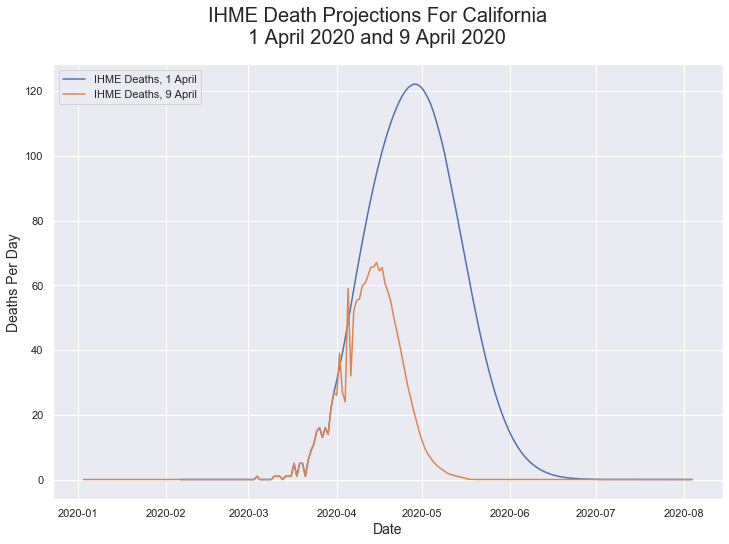

In [38]:
pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.1.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme1 = ihme[ihme.location_name == 'California'].copy()

pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.4.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme2 = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ihme1.date, ihme1.deaths_mean, label="IHME Deaths, 1 April")
ax.plot(ihme2.date, ihme2.deaths_mean, label="IHME Deaths, 9 April")
fig.suptitle("IHME Death Projections For California\n1 April 2020 and 9 April 2020", fontsize=20);
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Deaths Per Day', fontsize=14)
ax.legend(loc='upper left');

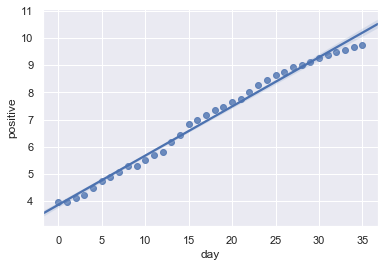

In [16]:
sns.regplot(ca.day, np.log(ca.positive))

In [17]:

x = ca.day.values.reshape(len(ca), 1)
y = np.log(ca.positive).values.reshape(len(ca), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", ca.day.corr(np.log(ca.positive)))

m = regr.coef_[0][0]
b = regr.intercept_[0]

Coefficients: [[0.18123458]] [3.86099079]
Correlation: 0.9953530100961495


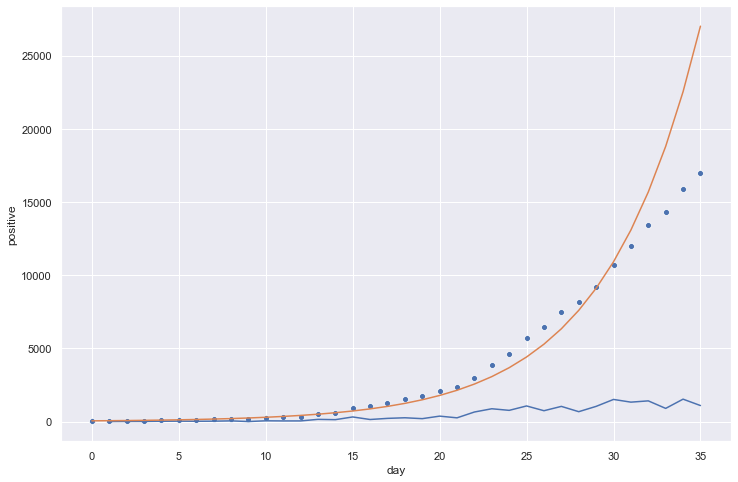

In [19]:
yp = np.exp(m*ca.day + b)

fig, ax = plt.subplots(figsize=(12,8))
#ax.plot(t.day, t.allbed_mean.cumsum())
sns.scatterplot(ca.day, ca.positive, ax=ax)
sns.lineplot(ca.day, ca.positive.diff(), ax=ax)
ax.plot(x,yp)

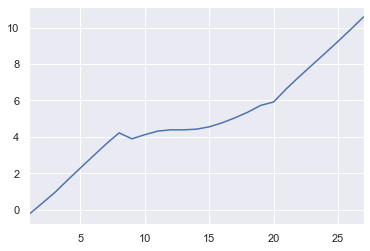

In [40]:
df.double_days.dropna().plot()